# Sentiment Analysis, Emotion Recognition and Hate Speech Detection on English tweets

Author: Bigarella Chiara

## 1 - Introduction

Natural Language Processing tasks have been widely studied in the context of big corpora, but, when applied to social media content, they have been proven to be harder. This is mainly due to the following reasons:

- Social media have a high-paced, conversational and idiosyncratic nature;
- There might be restriction in the number of characters allowed (this is the case on Twitter);
- Short texts cointains a limited amount of contextual cues;
- The lack of a unified evaluation framework makes it hard to compare different models.

In this project I am going to use BERTweet, a large-scale language model pretrained on English tweets, and I will evaluate its performances on three different NLP tasks:

- Emotion Recognition, which consists in recognizing the emotion evoked in a text (a tweet in this case);
- Hate Speech Detection, which consists in understanding whether a tweet is hateful or not towards certain target communities;
- Sentiment Analysis, i.e. the task of recognizing if the content of a text is positive, negative or neutral.

Below, you can see an example for each of the aforementioned tasks:

``` python
# Emotion Recognition
tweet = "Now that @user has snapchat back it's a constant battle to see who can get the ugliest snap of one another 😂🙃 #snap survival"
tokenized_tweet = tokenizer(tweet)
predictions = model_emotion.predict(tokenized_tweet)
preds = np.argmax(predictions.predictions, axis=-1)
preds

> 1 # Joy
```

``` python
# Hate Speech detection
tweet = "THIS WOMEN CAN DO ONLY ONE THINK, BACK INTO HER RAT🐀 HOLE NEVER TO COME OUT AGAIN🐀IF SHE SHOW UP ON SURFACE AM CALL…"
tokenized_tweet = tokenizer(tweet)
predictions = model_hate.predict(tokenized_tweet)
preds = np.argmax(predictions.predictions, axis=-1)
preds

> 1 # Hate
```

``` python
# Sentiment Analysis
tweet = "The Book of Souls sounds like it's going to be everything we love about Iron Maiden. Can't wait for sept 4th!"
tokenized_tweet = tokenizer(tweet)
predictions = model_sentiment.predict(tokenized_tweet)
preds = np.argmax(predictions.predictions, axis=-1)
preds

> 2 # Positive
```

## 2 - Model

[BERTweet](https://huggingface.co/vinai/bertweet-base) is the first large-scale language model based on the $BERT_{base}$ architecture, that has been pretrained using a corpus of 850M English Tweets. The training of the model is based on the $RoBERTa$ pre-training procedure, which leads to more rubust performances compared to the $BERT$ pretraining approach ([Nguyen et al. ,2020](https://aclanthology.org/2020.emnlp-demos.2/)).

BERT, which stands for **Bidirectional Encoder Representations from Transformers**, is a language representation model based on a multi-layer bidirectional Transformer encoder that jointly conditions on both left and right context in all layers. It has been pre-trained using a Masked Language Model (MLM) objective together with a Next Sentence Prediction task ([Devlin et al., 2019](https://arxiv.org/abs/1810.04805)).

The pre-trained BERT model can be easily finetuned by adding a single output layer and using the labeled data from the downstream task to update all the training parameters.


## 3 - Methodology

In order to perform the above mentioned NLP tasks,
I finetuned the $BERTweet_{base}$ model on three different datasets belonging to the [TweetEval](https://huggingface.co/datasets/tweet_eval) framework:

- For the **Emotion Recognition** task, I used the **TweetEval emotion** dataset, obtained from the SemEval2018, “Affects in Tweets” (Mohammad et al., 2018) dataset. This multi-label dataset has been transformed into a multi-class classification dataset by associating each tweet with a single emotion and by keeping only the four most common emotions, such as Anger, Joy, Sadness, Optimism.
- For **Hate Speech Detection**, I used the **TweetEval hate** dataset, based on the SemEval2019 Hateval challenge. Here each tweet is associated with a label stating whether the tweet is hatefull or not against immigrants and women.
- Finally, for the **Sentiment Analysis** task, I used the **TweetEval sentiment** dataset, based on the Semeval2017 dataset for Subtask A, where each tweet is a associated with a label specifying if the tweet's content is positive, negative or neutral.

A detailed overview of each dataset can be found in the Exploratory Data Analysis part of the Experiments section.




For each task, I performed the finetuning using two kinds of data:
- The original tweets, as they are provided in the datasets;
- Tweets that have been preprocessed using the `preprocess_tweet` function of the [pysentimiento](https://github.com/pysentimiento/pysentimiento) library.

The `preprocess_tweet` function performs the following actions on the original tweets:

1. It replaces all the emojis with the corresponding text, delimited by the word `emoji`.
2. It removes all the hashtag symbols (`#`).
3. Hashtags where the first letter of each word is capitalized, are split into the corresponding words and the first letters get changed to lowercase.
4. It replaces urls with the world `HTTPURL`.
5. It anonymizes all the users' mentions by replacing the usernames with `@USER`.

Here you can find an example of preprocessing of a tweet taken from the *emotion* dataset:
``` python
tweet = "Now that @user has snapchat back it's a constant battle to see who can get the ugliest snap of one another 😂🙃 #SnapSurvival"
preprocessed_tweet = preprocess_tweet(tweet, lang="en")
preprocessed_tweet

> "Now that @USER has snapchat back it's a constant battle to see who can get the ugliest snap of one another  emoji face with tears of joy emoji  emoji upside-down face emoji  snap survival"
```


During the finetuning process, I used a validation set to select the batch size and the number of epochs. To do so, I only considered the values suggested by the [Devlin et al., 2019](https://arxiv.org/abs/1810.04805) for finetuning BERT:
- Batch size: `16, 32`
- Number of epochs: `2, 3, 4`

Due to the limited hardware resources I had, I decided to not select the learning rate optimal value, but rather I used the default value of the Hugging Face [TrainingArguments](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) class, i.e. `5e-5`. However, this value is among the suggested learning rates for the finetuning of BERT (`5e-5, 3e-5, 2e-5`).

Finally, I evaluated the resulting models by computing the following metrics on the corresponding test sets:
- Accuracy
- Macro-averaged precision: $P = \frac{TP}{TP + FP}$
- Macro-averaged recall: $R = \frac{TP}{TP + FN}$
- Macro-averaged $F_{1}$ score: $F_{1} = 2 \frac{P * R}{P + R}$

In particular, macro-averaged $F_{1}$  score is the metric suggested by the TweetEval framework to evaluate Emotion Recognition, Hate Speech Detection and Sentiment Analysis on tweets.

However, note that the macro average is an unweighted mean and therefore it does not take label imbalance into account.

## 4 - Experiments

This section contains the entire code developed to carry out the project, and its related output.

### 4.1 Setup

In [ ]:
! pip uninstall folium --yes
! pip install datasets

! pip install pysentimiento

! pip install transformers
# ! pip install emoji==0.6.0

! pip install colorama

In [ ]:
from collections import defaultdict
import colorama
from colorama import Fore
from datasets import load_dataset, load_metric
import matplotlib.pyplot as plt
import numpy as np
from pysentimiento.preprocessing import preprocess_tweet
import seaborn as sns

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, \
    AdamW, get_linear_schedule_with_warmup, TrainingArguments, Trainer

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
COLORS_PALETTE = ["#d952a1", "#3C9BFA",  "#04C896",  "#FCB405",  "#7C5CFF", "#FC8204"]
sns.set_palette(sns.color_palette(COLORS_PALETTE))

RANDOM_SEED = 5
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
BERTWEET_BASE = 'vinai/bertweet-base'

### 4.2 - Exploratory Data Analysis

In this section I downloaded the data from the TweetEval datasets related to Emotion Recognition, Hate Speech Detection and Sentiment Analysis, and I performed some explorary data analysis.

The table below shows a summary of the datasets. Note that each dataset is already split into train, validation and test set.

Dataset   | Lables | Train | Validation | Test
----------|--------| ------| -----------| ----
emotion   | ['anger', 'joy', 'optimism', 'sadness']| 3257  | 374        | 1421
hate      | ['non-hate', 'hate'] | 9000  | 1000       | 2970
sentiment | ['negative', 'neutral', 'positive'] | 45615 | 2000       | 12284


As we can see, the *emotion* and *hate* datasets are pretty small compared to the *sentiment* dataset. This might lead to lower performances in the Emotion Recognition and Hate Speech Detection tasks.


In [ ]:
# BERTweet tokenizer
tokenizer = AutoTokenizer.from_pretrained(BERTWEET_BASE)

In [ ]:
# Helper functions

def dataset_overview(name, train, val, test):
  """ Print the dataset's information. """

  print(f"** {name} **\n")
  print("Features:", train.features)
  print("Training examples:", train.num_rows)
  print("Validation examples:", val.num_rows)
  print("Test examples:", test.num_rows)


def show_data_examples(data, first, last, color=Fore.BLUE):
  """ Print some dataset examples. """

  print('EXAMPLES:\n')
  for idx in range(first, last):
    tweet = data['text'][idx]
    label = data['label'][idx]
    print(f"{Fore.BLACK} {idx + 1}. {tweet} -> {color} {data.features['label'].int2str(label)}")


def labels_piechart(train, val, test):
  """ Generate three pie charts, one for the train, one for the validation and 
  one for the test sets. Each pie chart shows the labels frequencies as 
  percentages. """

  classes, counts = np.unique(train['label'], return_counts=True)
  val_classes, val_counts = np.unique(val['label'], return_counts=True)
  test_classes, test_counts = np.unique(test['label'], return_counts=True)

  # Pie chart, where the slices will be ordered and plotted counter-clockwise:
  fig1, ax = plt.subplots(1, 3, figsize=(20, 8))

  ax[0].pie(counts, labels=classes, autopct='%1.1f%%', startangle=90, textprops={'size':15})
  ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  ax[0].set_title("Training set", size=15)

  ax[1].pie(val_counts, labels=val_classes, autopct='%1.1f%%', startangle=90, textprops={'size':15})
  ax[1].axis('equal')
  ax[1].set_title("Validation set", size=15)

  ax[2].pie(test_counts, labels=test_classes, autopct='%1.1f%%', startangle=90, textprops={'size':15})
  ax[2].axis('equal')
  ax[2].set_title("Test set", size=15)

  plt.show()


def count_sequence_length(train, val, test):
  """ Count the length of the token's sequences in the entire datasets (train,
  validation and test sets). """

  token_lens = []

  for txt in train['text']:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

  for txt in val['text']:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

  for txt in test['text']:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

  return token_lens


def plot_sequence_length(token_lens):
  """ Plot an histogram of the token sequence lengths. """

  fig1, ax = plt.subplots(1, 1, figsize=(20, 8))

  sns.histplot(token_lens, kde=True)

  plt.xlim([0, 150]);
  plt.xlabel('Tokens');


def preprocessing_function(example):
  """ Preprocess a tweet using the 'preprocess_tweet' function. """
  
  example_cp = example.copy()
  preprocessed_tweet = preprocess_tweet(example_cp['text'], lang="en")
  example_cp['text'] = preprocessed_tweet
  return example_cp

#### 4.2.1 - Emotion Recognition

In [ ]:
train_emotion = load_dataset('tweet_eval', 'emotion',  split='train')
val_emotion= load_dataset('tweet_eval', 'emotion',  split='validation')
test_emotion = load_dataset('tweet_eval', 'emotion',  split='test')

In [ ]:
# Dataset overview
dataset_overview('Emotion dataset', train_emotion, val_emotion, test_emotion)

** Emotion dataset **

Features: {'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=4, names=['anger', 'joy', 'optimism', 'sadness'], id=None)}
Training examples: 3257
Validation examples: 374
Test examples: 1421


**Class frequency**

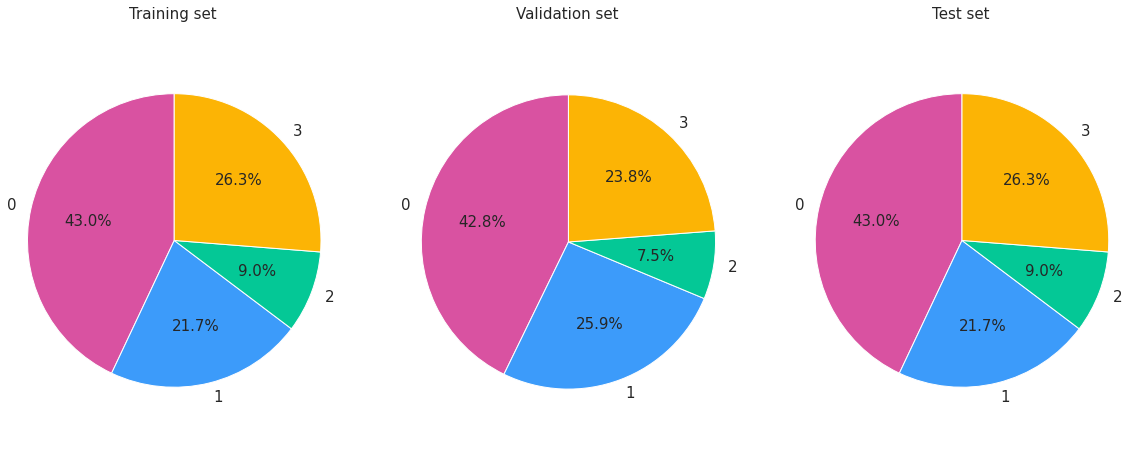

In [ ]:
labels_piechart(train_emotion, val_emotion, test_emotion)

# 0 -> anger
# 1 -> joy
# 2 -> optimism
# 3 -> sadness

From the pie charts above, we can see that the dataset is not well balanced: `anger` is the predominant class, while `optimism` is associated to less than 10% of the dataset's examples. However, the classes' proportions are kept the same in the training, validation and test splits.

In [ ]:
# Data examples
show_data_examples(train_emotion, 200, 220, Fore.MAGENTA)

EXAMPLES:

 201. Now that @user has snapchat back it's a constant battle to see who can get the ugliest snap of one another 😂🙃 #snap survival ->  joy
 202. @user He's just too raging to type properly... Ha ha! ->  anger
 203. Pakistan continues to treat #terror as a matter of state policy says @user #UriAttack ->  anger
 204. i have so much hair it's a nightmare but it's also very soft so it guess it's a win-lose situation ->  optimism
 205. @user @user whatever Sam is holding on your tee looks like it's got a droop on 😂 ->  joy
 206. One step forward, two steps backward, the link to RogerFedererShop doesn´t work.😰 I am losing hope about Roger Federer new Website #sadness ->  sadness
 207. The Pats are awesome. Belichick is awesome ...they just are. ->  joy
 208. Don't join @user they put the phone down on you, talk over you and are rude. Taking money out of my acc willynilly! ->  anger
 209. @user @user @user @user Take 2k out of it the numbers on madden are low and have dropped and p

The tweets contained in the dataset have been partially preprocessed: the users mentions have been anonymized and substitudet by `@user`, while emoji and hastags have been kept.




**Sequence length**

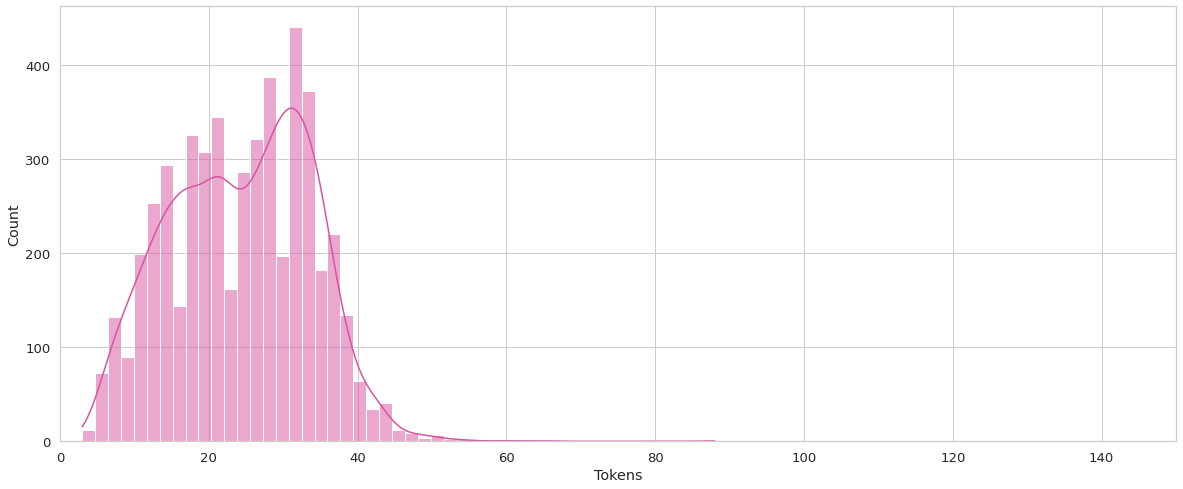

In [ ]:
sequence_lengths = count_sequence_length(train_emotion, val_emotion, test_emotion)
plot_sequence_length(sequence_lengths)

In [ ]:
max(sequence_lengths)

88

In [ ]:
# number of tweets with more than 60 tokens
sl = [x for x in sequence_lengths if x > 60]
len(sl)

3

From the histogram above, we can see that most of the tokenized tweets have less then 60 tokens. However, the longest tokenized tweet has 88 tokens.

**Tweet Preprocessing**

In [ ]:
train_emotion_prep = train_emotion.map(preprocessing_function)
val_emotion_prep = val_emotion.map(preprocessing_function)
test_emotion_prep = test_emotion.map(preprocessing_function)

In [ ]:
# Preprocessed tweets examples
show_data_examples(train_emotion_prep, 200, 220, Fore.MAGENTA)

EXAMPLES:

 201. Now that @USER has snapchat back it's a constant battle to see who can get the ugliest snap of one another  emoji face with tears of joy emoji  emoji upside-down face emoji  snap survival ->  joy
 202. @USER He's just too raging to type properly... Ha ha! ->  anger
 203. Pakistan continues to treat terror as a matter of state policy says @USER uri attack ->  anger
 204. i have so much hair it's a nightmare but it's also very soft so it guess it's a win-lose situation ->  optimism
 205. @USER @USER whatever Sam is holding on your tee looks like it's got a droop on  emoji face with tears of joy emoji ->  joy
 206. One step forward, two steps backward, the link to RogerFedererShop doesnt work. emoji anxious face with sweat emoji  I am losing hope about Roger Federer new Website sadness ->  sadness
 207. The Pats are awesome. Belichick is awesome ...they just are. ->  joy
 208. Don't join @USER they put the phone down on you, talk over you and are rude. Taking money out of

The preprocessing function has performed the following actions on the original tweets:
- All the emoji have been replaced with the corresponding text, delimited by the word `emoji` (for example, in tweet number 201, 😂🙃 have been replaced with `emoji face with tears of joy emoji  emoji upside-down face emoji`).
- All the hashtag symbols (`#`) have been removed.
- Hashtags where the first letter of each word is capitalized, have been split into the corresponding word and the first letters have been changed to lowercase (for example, in tweet number 210, the hashtag `#BlackLivesmatter` has been turned into `black livesmatter`).


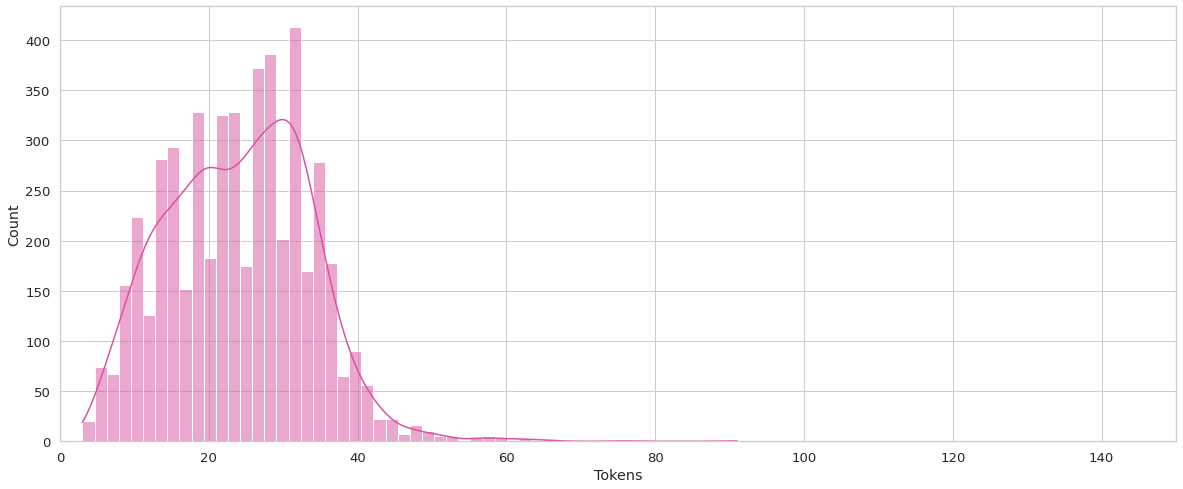

In [ ]:
# preprocessed tweets sequence length
sequence_lengths = count_sequence_length(train_emotion_prep, val_emotion_prep, test_emotion_prep)
plot_sequence_length(sequence_lengths)

In [ ]:
max(sequence_lengths)

91

In [ ]:
# number of tweets with more than 60 tokens
sl = [x for x in sequence_lengths if x > 60]
len(sl)

9

From the histogram above, we can see that most of the tokenized preprocessed tweets have less then 60 tokens. However, the longest tokenized tweet has 91 tokens.

#### 4.2.2 -  Hate Speech Detection

In [ ]:
train_hate = load_dataset('tweet_eval', 'hate',  split='train')
val_hate = load_dataset('tweet_eval', 'hate',  split='validation')
test_hate = load_dataset('tweet_eval', 'hate',  split='test')

In [ ]:
# Dataset overview
dataset_overview('Hate Speech dataset', train_hate, val_hate, test_hate)

** Hate Speech dataset **

Features: {'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=2, names=['non-hate', 'hate'], id=None)}
Training examples: 9000
Validation examples: 1000
Test examples: 2970


**Class frequency**

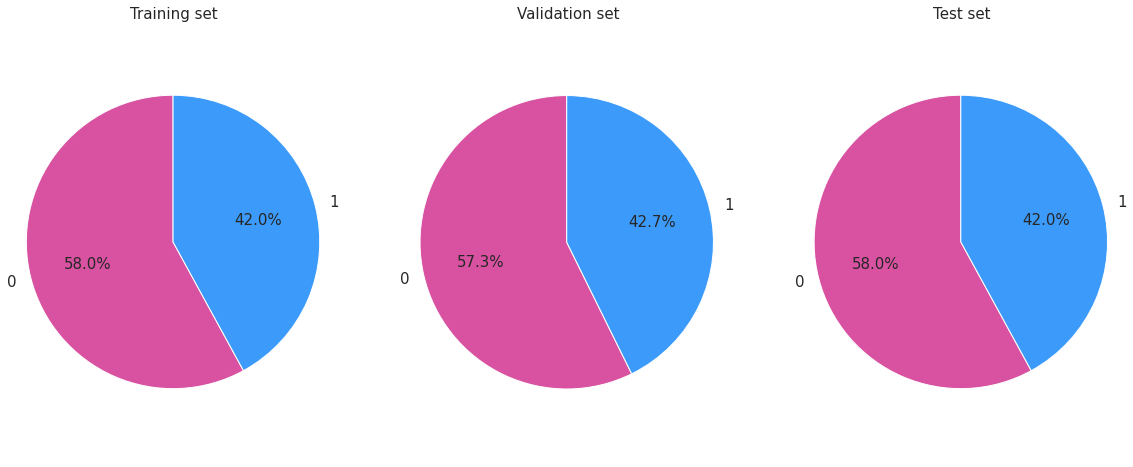

In [ ]:
labels_piechart(train_hate, val_hate, test_hate)

# 0 -> non-hate
# 1 -> hate

As we can see from the pie charts above, the dataset is almost balanced, with a small prevalence of non-hateful examples. Also for this dataset, the classes' proportions are kept the same in the training, validation and test splits.

In [ ]:
# Data examples
show_data_examples(train_hate, 175, 200, Fore.LIGHTRED_EX)

EXAMPLES:

 176. THIS WOMEN CAN DO ONLY ONE THINK, BACK INTO HER RAT🐀 HOLE NEVER TO COME OUT AGAIN🐀IF SHE SHOW UP ON SURFACE AM CALL… ->  hate
 177. #ACTNOW! #USA #EB5 #EB5Visa #Immigrant #Foreign #Investor #Visa Program Laws ARE Changing! $500k #Investment. Payment plans available. Use #bitcoin #ether #cryptocurrency. Become a US Citizen! Visit us at Contact us TODAY at gbibuildingco@outlook.com. RT ->  non-hate
 178. The Latest: Spanish PM lets migrant boat dock at Valencia    You idiots are killing Spain with islamists... ->  hate
 179. Afghan and Pakistani migrants were shot at as they tried to invade Hungary - Free Speech Time - @user ->  non-hate
 180. @user shut the fuck up hes not gonna dick you was gonna send u this dope steroline edit but u can go cry to olly ->  hate
 181. you low life scum, pathetic, deprave, pile of shit, maggots. like i said that brainless skank bitch should've died… ->  hate
 182. @user @user bitch we r now TxF sluts ->  non-hate
 183. @user At the very 

The tweets contained in the dataset have been partially preprocessed: the users mentions have been anonymized and substitudet by `@user`, while emoji and hastags have been kept.

**Sequence length**

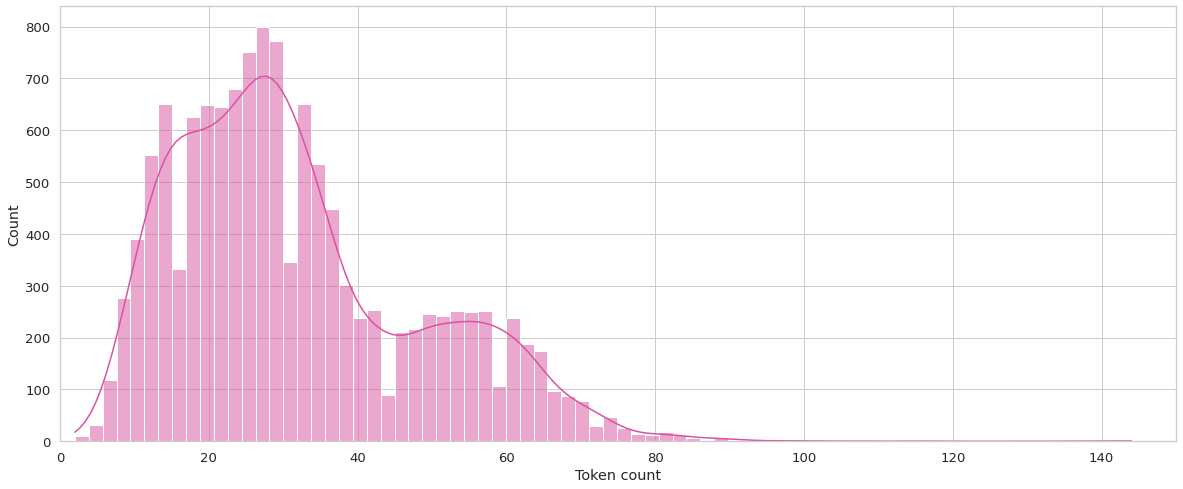

In [ ]:
sequence_lengths = count_sequence_length(train_hate, val_hate, test_hate)
plot_sequence_length(sequence_lengths)

In [ ]:
max(sequence_lengths)

144

In [ ]:
# number of tweets with more than 100 tokens
sl = [x for x in sequence_lengths if x > 100]
len(sl)

5

From the histogram above, we can see that most of the tokenized tweets have less then 100 tokens. However, the longest tokenized tweet has 144 tokens.

**Tweet Preprocessing**

In [ ]:
train_hate_prep = train_hate.map(preprocessing_function)
val_hate_prep = val_hate.map(preprocessing_function)
test_hate_prep = test_hate.map(preprocessing_function)

In [ ]:
show_data_examples(train_hate_prep, 175, 200, Fore.LIGHTRED_EX)

EXAMPLES:

 176. THIS WOMEN CAN DO ONLY ONE THINK, BACK INTO HER RAT emoji rat emoji  HOLE NEVER TO COME OUT AGAIN emoji rat emoji IF SHE SHOW UP ON SURFACE AM CALL ->  hate
 177. actnow! usa eb5 eb5 visa immigrant foreign investor visa Program Laws ARE Changing! $500k investment. Payment plans available. Use bitcoin ether cryptocurrency. Become a US Citizen! Visit us at Contact us TODAY at gbibuildingco@HTTPURL. RT ->  non-hate
 178. The Latest: Spanish PM lets migrant boat dock at Valencia   You idiots are killing Spain with islamists... ->  hate
 179. Afghan and Pakistani migrants were shot at as they tried to invade Hungary - Free Speech Time - @USER ->  non-hate
 180. @USER shut the fuck up hes not gonna dick you was gonna send u this dope steroline edit but u can go cry to olly ->  hate
 181. you low life scum, pathetic, deprave, pile of shit, maggots. like i said that brainless skank bitch should've died ->  hate
 182. @USER @USER bitch we r now TxF sluts ->  non-hate
 183. @USE

The preprocessing function has performed the actions described above in the preprocessing section of the *emotion* dataset.



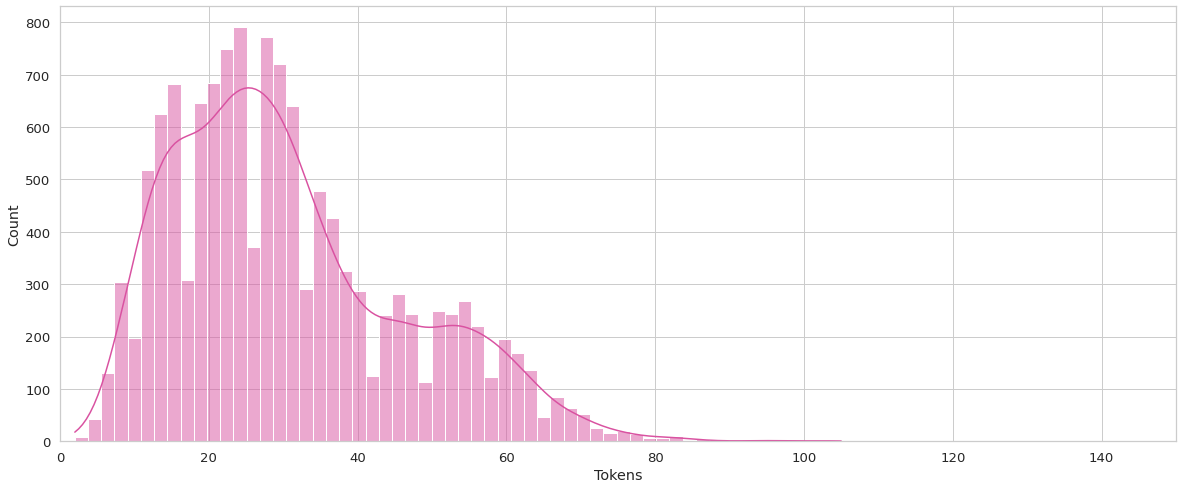

In [ ]:
sequence_lengths = count_sequence_length(train_hate_prep, val_hate_prep, test_hate_prep)
plot_sequence_length(sequence_lengths)

In [ ]:
max(sequence_lengths)

105

In [ ]:
# number of tweets with more than 100 tokens
sl = [x for x in sequence_lengths if x > 100]
len(sl)

3

From the histogram above, we can see that most of the tokenized preprocessed tweets have less then 100 tokens. However, the longest tokenized tweet has 105 tokens.

#### 4.2.3 - Sentiment Analysis

In [ ]:
train_sentiment = load_dataset('tweet_eval', 'sentiment',  split='train')
val_sentiment = load_dataset('tweet_eval', 'sentiment',  split='validation')
test_sentiment = load_dataset('tweet_eval', 'sentiment',  split='test')

In [ ]:
# Dataset overview
dataset_overview('Sentiment Analysis dataset', train_sentiment, val_sentiment, test_sentiment)

** Sentiment Analysis dataset **

Features: {'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=3, names=['negative', 'neutral', 'positive'], id=None)}
Training examples: 45615
Validation examples: 2000
Test examples: 12284


**Class frequency**

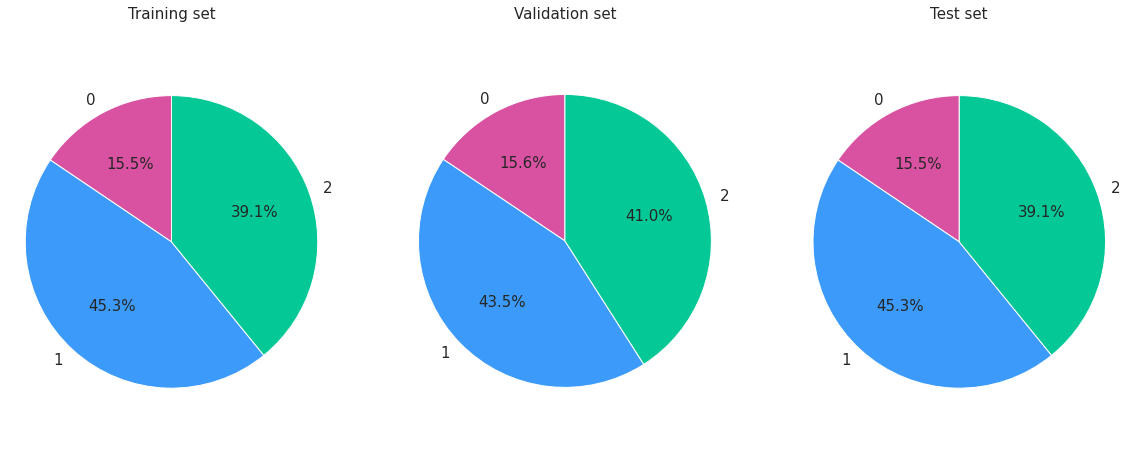

In [ ]:
labels_piechart(train_sentiment, val_sentiment, test_sentiment)

# 0 -> negative
# 1 -> neutral
# 2 -> positive

As we can see from the pie charts above, the dataset is not balanced since the `negative` examples are just the 15% of the dataset. However, the other two classes are present in similar proportions. Also in this case, the classes' proportions are kept the same in the training, validation and test splits.

In [ ]:
# Data examples
show_data_examples(train_sentiment, 660, 680, Fore.LIGHTGREEN_EX)

EXAMPLES:

 661. @user Dana white reportedly said holly will have to wait to fight Ronda in July but she wants to fight in February or March smgdh ->  neutral
 662. @user it\u2019s time to call in the CBB...Monday is going down! ->  negative
 663. "it's august 8th and still no Frank Ocean album, when will this terror end" ->  negative
 664. Is your computer acting like it is still on Labor Day break? Just reboot - It's patch Tuesday :) ->  neutral
 665. We didn 39t make The Hills Tuesday night session at PaleyFest but those ->  neutral
 666. AC Milan reportedly want Miralem Pjanic to join the San Siro in January #FootballFanatic ->  neutral
 667. @user You can now Listen new song cover of @user  Love yourself"" by: Justin bieber heres the link~&gt;https://t.co/Mq1tVGbqxm""" ->  neutral
 668. "Bucks backcourt mates Brandon Jennings and Monta Ellis had a \""""little brother-big brother\"""" talk on Sunday\u002c as Jennings described it." ->  neutral
 669. Capello: I\u2019ll Tweak Lineup 

The tweets contained in the dataset have been partially preprocessed: the users mentions have been anonymized and substitudet by `@user`, while emoji and hastags have been kept.

**Sequence length**

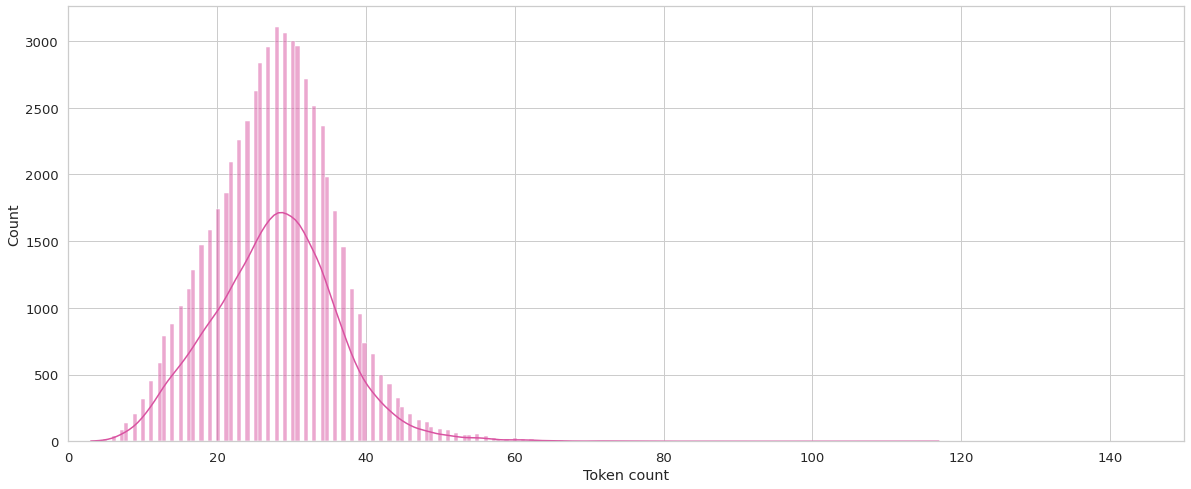

In [ ]:
sequence_lengths = count_sequence_length(train_sentiment, val_sentiment, test_sentiment)
plot_sequence_length(sequence_lengths)

In [ ]:
max(sequence_lengths)

117

In [ ]:
# number of tweets with more than 80 tokens
sl = [x for x in sequence_lengths if x > 80]
len(sl)

5

From the histogram above, we can see that most of the tokenized tweets have less then 80 tokens. However, the longest tokenized tweet has 117 tokens.

**Tweet Preprocessing**

In [ ]:
train_sentiment_prep = train_sentiment.map(preprocessing_function)
val_sentiment_prep = val_sentiment.map(preprocessing_function)
test_sentiment_prep = test_sentiment.map(preprocessing_function)

In [ ]:
show_data_examples(train_sentiment_prep, 10, 100, Fore.LIGHTGREEN_EX)

EXAMPLES:

 11. @USER Well said on HMW. Can you now address why Texans fans file out of the stadium midway through the 4th qtr of every game? ->  neutral
 12. Just said hello to Dennis Kucinich as he walked casually through campus with his hotwife. He's on 22nd st! ->  neutral
 13. Super excited for homecoming Saturday with Monroe! :D my new nephew is here but I can\u2019t see him :( ->  positive
 14. That sucks if you have to take the SATs tomorrow ->  negative
 15. @USER  6 tickets for Sam smith concert  Sept 30 cheap! Flew our family of 6 here fir the concert! BEYOND UPSET! ->  neutral
 16. "Fiorentina have reportedly opened talks with Chelsea over taking the 20yr old Kurt Zuoma on loan in January." ->  neutral
 17. Creighton Volleyball leads 8-5 early in 2nd set. Match becomes even bigger with both Wichita St. & Missouri State down 0-1 at home tonight. ->  positive
 18. This time tomorrow...we'll have the Iron on. Iron Maiden pieces Drops tomorrow nights. ->  positive
 19. Amy Schu

The preprocessing function has performed the actions described in the previous sections.

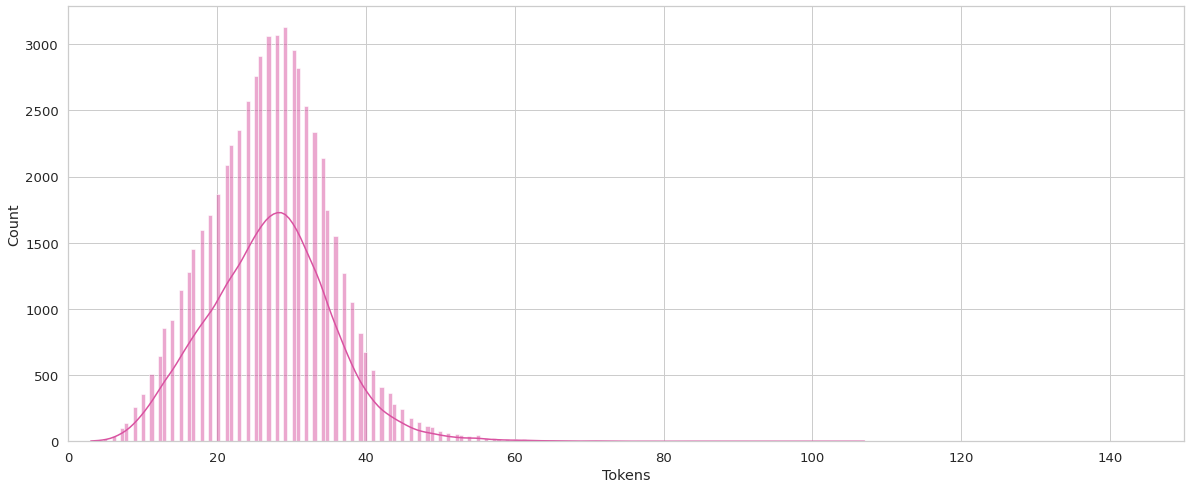

In [ ]:
sequence_lengths = count_sequence_length(train_sentiment_prep, val_sentiment_prep, test_sentiment_prep)
plot_sequence_length(sequence_lengths)

In [ ]:
max(sequence_lengths)

107

In [ ]:
# number of tweets with more than 80 tokens
sl = [x for x in sequence_lengths if x > 80]
len(sl)

6

From the histogram above, we can see that most of the tokenized preprocessed tweets have less then 80 tokens. However, the longest tokenized tweet has 107 tokens.

### 4.3 - Data Tokenization

In this section, tweets are tokenized by using the BERTweet tokenizer. I first applied the tokenization to the original tweets. Then, I tokenized the preprocessed tweets.

To tokenize the tweets, I used the `max_length` padding option, which truncates the tokenized tweets to the same length. Most of the original tweets have a length below 80, however, in the *hate* and *sentiment* datasets the longest tokenized tweets have 144 and 117 tokens respectively.

I decided to use a max length of 100 so that most of the tweets in the three datasets won't be truncated.


In [ ]:
MAX_LEN = 100

In [ ]:
# helper functions

def tokenize_function(examples):
  """ Call the tokenizer on a tweet. """

  return tokenizer(examples["text"], padding='max_length', truncation=True, max_length=MAX_LEN)


def tokenize_datasets(train, val, test):
  """ Tokenize the tweets in the training, validation and test sets. After that,
  the 'label' column is renamed to 'labels' and the 'text' column is removed. 
  Finally, the dataset's format is set to 'torch'. The resulting datasets have the
  columns required by the BERTweet tokenizer."""

  train_tokenized_dataset = train.map(tokenize_function, batched=True)
  train_tokenized_dataset = train_tokenized_dataset.rename_column('label', 'labels')
  train_tokenized_dataset = train_tokenized_dataset.remove_columns(['text'])
  train_tokenized_dataset = train_tokenized_dataset.with_format('torch')

  val_tokenized_dataset = val.map(tokenize_function, batched=True)
  val_tokenized_dataset = val_tokenized_dataset.rename_column('label', 'labels')
  val_tokenized_dataset = val_tokenized_dataset.remove_columns(['text'])
  val_tokenized_dataset = val_tokenized_dataset.with_format('torch')

  test_tokenized_dataset = test.map(tokenize_function, batched=True)
  test_tokenized_dataset = test_tokenized_dataset.rename_column('label', 'labels')
  test_tokenized_dataset = test_tokenized_dataset.remove_columns(['text'])
  test_tokenized_dataset = test_tokenized_dataset.with_format('torch')

  return train_tokenized_dataset, val_tokenized_dataset, test_tokenized_dataset


#### 4.3.1 - Emotion Recognition

**Original Tweet Tokenization**

In [ ]:
# Data tokenization
train_tokenized_emotion, val_tokenized_emotion, test_tokenized_emotion = tokenize_datasets(train_emotion, val_emotion, test_emotion)


In [ ]:
# column names of the tokenized tweets
train_tokenized_emotion.column_names

['labels', 'input_ids', 'token_type_ids', 'attention_mask']

**Preprocessed Tweet Tokenization**

In [ ]:
# Data tokenization
train_tokenized_emotion_prep, val_tokenized_emotion_prep, test_tokenized_emotion_prep = tokenize_datasets(train_emotion_prep, val_emotion_prep, test_emotion_prep)

#### 4.3.2 - Hate Speech Detection

**Original Tweet Tokenization**

In [ ]:
# Data tokenization
train_tokenized_hate, val_tokenized_hate, test_tokenized_hate = tokenize_datasets(train_hate, val_hate, test_hate)

**Preprocessed Tweet Tokenization**

In [ ]:
# Data tokenization
train_tokenized_hate_prep, val_tokenized_hate_prep, test_tokenized_hate_prep = tokenize_datasets(train_hate_prep, val_hate_prep, test_hate_prep)

#### 4.3.3 - Sentiment Analysis

**Original Tweet Tokenization**

In [ ]:
# Data tokenization
train_tokenized_sentiment, val_tokenized_sentiment, test_tokenized_sentiment = tokenize_datasets(train_sentiment, val_sentiment, test_sentiment)

**Preprocessed Tweet Tokenization**

In [ ]:
# Data tokenization
train_tokenized_sentiment_prep, val_tokenized_sentiment_prep, test_tokenized_sentiment_prep = tokenize_datasets(train_sentiment_prep, val_sentiment_prep, test_sentiment_prep)

### 4.4 - Model finetuning

This section contains the code used to finetuned $BERTeet_{base}$ on both the original and the preprocessed tweets of the *emotion*, *hate* and *sentiment* datasets.

For each dataset and for each kind of data, I selected the model with the best validation accuracy. The table below shows a summary of the hyperparameters of the best models.

Dataset                 | Batch Size | Number of Epochs | Validation Accuracy
----------------------  |------------| ----| -------
emotion (original)      | 32         | 3   | 82.4%
emotion (preprocessed)  | 16         | 2   | 80.7%
hate (original)         | 32         | 2   | 80.3%
hate (preprocessed)     | 16         | 2   | 78.1%
sentiment (original)    | 16         | 2   | 73.7%
sentiment (preprocessed)| 16         | 4   | 72.1%

As we can see, most of the models reached the best validation accuracy in 2 epochs, using a batch size of 16.

In [ ]:
accuracy = load_metric("accuracy")

In [ ]:
# Hyperparameters
batch_sizes = [16, 32]
epochs = [2, 3, 4]

In [ ]:
def compute_accuracy(eval_pred):
  """ Compute accuracy on the model's predictions. """
  
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

#### 4.4.1 - Emotion Recognition

In [ ]:
num_classes = train_emotion.features['label'].num_classes
bertweet_emotion = AutoModelForSequenceClassification.from_pretrained(BERTWEET_BASE, num_labels=num_classes)

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidde

**Original data**

In [ ]:
best_model_emotion = None
best_accuracy_emotion = 0
best_epoch_emotion = 0
best_batch_size_emotion = 0

models_emotion = []

for epoch in epochs:
  for batch_size in batch_sizes:

    args = TrainingArguments(output_dir='trainer_emotion_'+str(batch_size)+'_'+str(epoch),
                              evaluation_strategy="epoch",
                              num_train_epochs=epoch,
                              per_device_train_batch_size=batch_size)

    trainer = Trainer(
        model=bertweet_emotion,
        args=args,
        train_dataset=train_tokenized_emotion,
        eval_dataset=val_tokenized_emotion,
        compute_metrics=compute_accuracy,
    )

    trainer.train()
  
    predictions = trainer.predict(val_tokenized_emotion)
    preds = np.argmax(predictions.predictions, axis=-1)
    val_accuracy = accuracy.compute(predictions=preds, references=predictions.label_ids)['accuracy']

    print(f'{Fore.MAGENTA} \nValidation accuracy (batch size {batch_size} and epochs {epoch}): {val_accuracy}\n {Fore.BLACK}')
    
    models_emotion.append(dict(val_accuracy=val_accuracy,
                       batch_size=batch_size,
                       epochs=epoch
                       ))

    if val_accuracy > best_accuracy_emotion:
      best_accuracy_emotion = val_accuracy
      best_model_emotion = trainer
      best_epoch_emotion = epoch
      best_batch_size_emotion = batch_size

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3257
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 408


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.618158,0.799465
2,No log,0.539504,0.812834


***** Running Evaluation *****
  Num examples = 374
  Batch size = 8
***** Running Evaluation *****
  Num examples = 374
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 374
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3257
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 204


 
Validation accuracy (batch size 16 and epochs 2): 0.8128342245989305
 


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.514170,0.815508
2,No log,0.579458,0.799465


***** Running Evaluation *****
  Num examples = 374
  Batch size = 8
***** Running Evaluation *****
  Num examples = 374
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 374
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3257
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 612


 
Validation accuracy (batch size 32 and epochs 2): 0.7994652406417112
 


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.762361,0.804813
2,No log,0.785664,0.823529
3,0.226000,0.871312,0.818182


***** Running Evaluation *****
  Num examples = 374
  Batch size = 8
***** Running Evaluation *****
  Num examples = 374
  Batch size = 8
Saving model checkpoint to trainer_emotion_16_3/checkpoint-500
Configuration saved in trainer_emotion_16_3/checkpoint-500/config.json
Model weights saved in trainer_emotion_16_3/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 374
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 374
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3257
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 306


 
Validation accuracy (batch size 16 and epochs 3): 0.8181818181818182
 


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.042687,0.783422
2,No log,1.029904,0.799465
3,No log,1.006998,0.823529


***** Running Evaluation *****
  Num examples = 374
  Batch size = 8
***** Running Evaluation *****
  Num examples = 374
  Batch size = 8
***** Running Evaluation *****
  Num examples = 374
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 374
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3257
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 816


 
Validation accuracy (batch size 32 and epochs 3): 0.8235294117647058
 


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.052484,0.802139
2,No log,1.157816,0.818182
3,0.095700,1.282906,0.796791
4,0.095700,1.412571,0.783422


***** Running Evaluation *****
  Num examples = 374
  Batch size = 8
***** Running Evaluation *****
  Num examples = 374
  Batch size = 8
Saving model checkpoint to trainer_emotion_16_4/checkpoint-500
Configuration saved in trainer_emotion_16_4/checkpoint-500/config.json
Model weights saved in trainer_emotion_16_4/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 374
  Batch size = 8
***** Running Evaluation *****
  Num examples = 374
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 374
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3257
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 408


 
Validation accuracy (batch size 16 and epochs 4): 0.7834224598930482
 


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.436661,0.791444
2,No log,1.655609,0.783422
3,No log,1.443683,0.802139
4,No log,1.399361,0.810160


***** Running Evaluation *****
  Num examples = 374
  Batch size = 8
***** Running Evaluation *****
  Num examples = 374
  Batch size = 8
***** Running Evaluation *****
  Num examples = 374
  Batch size = 8
***** Running Evaluation *****
  Num examples = 374
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 374
  Batch size = 8


 
Validation accuracy (batch size 32 and epochs 4): 0.8101604278074866
 


In [ ]:
print('** Best model for Emotion Recognition **')
print(f'batch size: {best_batch_size_emotion}, epochs: {best_epoch_emotion}, validation accuracy: {best_accuracy_emotion}')


** Best model for Emotion Recognition **
batch size: 32, epochs: 3, validation accuracy: 0.8235294117647058


**Preprocessed data**

In [ ]:
best_model_emotion_prep = None
best_accuracy_emotion_prep = 0
best_epoch_emotion_prep = 0
best_batch_size_emotion_prep = 0

models_emotion_prep = []

for epoch in epochs:
  for batch_size in batch_sizes:

    args = TrainingArguments(output_dir='trainer_emotion_prep'+str(batch_size)+'_'+str(epoch),
                              evaluation_strategy="epoch",
                              num_train_epochs=epoch,
                              per_device_train_batch_size=batch_size)
    
    trainer = Trainer(
        model=bertweet_emotion,
        args=args,
        train_dataset=train_tokenized_emotion_prep,
        eval_dataset=val_tokenized_emotion_prep,
        compute_metrics=compute_accuracy,
    )

    trainer.train()
  
    predictions = trainer.predict(val_tokenized_emotion_prep)
    preds = np.argmax(predictions.predictions, axis=-1)
    val_accuracy = accuracy.compute(predictions=preds, references=predictions.label_ids)['accuracy']

    print(f'{Fore.MAGENTA} \nValidation accuracy (batch size {batch_size} and epochs {epoch}): {val_accuracy}\n {Fore.BLACK}')
    
    models_emotion_prep.append(dict(val_accuracy=val_accuracy,
                       batch_size=batch_size,
                       epochs=epoch
                       ))

    if val_accuracy > best_accuracy_emotion_prep:
      best_accuracy_emotion_prep = val_accuracy
      best_model_emotion_prep = trainer
      best_epoch_emotion_prep = epoch
      best_batch_size_emotion_prep = batch_size

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3257
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 408


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.760274,0.783422
2,No log,1.571827,0.807487


***** Running Evaluation *****
  Num examples = 374
  Batch size = 8
***** Running Evaluation *****
  Num examples = 374
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 374
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3257
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 204


 
Validation accuracy (batch size 16 and epochs 2): 0.8074866310160428
 


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.532327,0.812834
2,No log,1.723712,0.791444


***** Running Evaluation *****
  Num examples = 374
  Batch size = 8
***** Running Evaluation *****
  Num examples = 374
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 374
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3257
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 612


 
Validation accuracy (batch size 32 and epochs 2): 0.7914438502673797
 


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.900770,0.791444
2,No log,1.761048,0.794118
3,0.055300,1.865750,0.786096


***** Running Evaluation *****
  Num examples = 374
  Batch size = 8
***** Running Evaluation *****
  Num examples = 374
  Batch size = 8
Saving model checkpoint to trainer_emotion_prep16_3/checkpoint-500
Configuration saved in trainer_emotion_prep16_3/checkpoint-500/config.json
Model weights saved in trainer_emotion_prep16_3/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 374
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 374
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3257
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 306


 
Validation accuracy (batch size 16 and epochs 3): 0.786096256684492
 


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.822865,0.804813
2,No log,2.159995,0.759358
3,No log,1.867091,0.783422


***** Running Evaluation *****
  Num examples = 374
  Batch size = 8
***** Running Evaluation *****
  Num examples = 374
  Batch size = 8
***** Running Evaluation *****
  Num examples = 374
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 374
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3257
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 816


 
Validation accuracy (batch size 32 and epochs 3): 0.7834224598930482
 


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.536469,0.791444
2,No log,1.657659,0.788770
3,0.050400,1.725545,0.796791
4,0.050400,1.787939,0.788770


***** Running Evaluation *****
  Num examples = 374
  Batch size = 8
***** Running Evaluation *****
  Num examples = 374
  Batch size = 8
Saving model checkpoint to trainer_emotion_prep16_4/checkpoint-500
Configuration saved in trainer_emotion_prep16_4/checkpoint-500/config.json
Model weights saved in trainer_emotion_prep16_4/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 374
  Batch size = 8
***** Running Evaluation *****
  Num examples = 374
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 374
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3257
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 408


 
Validation accuracy (batch size 16 and epochs 4): 0.7887700534759359
 


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.052785,0.786096
2,No log,2.123596,0.772727
3,No log,2.149477,0.764706
4,No log,2.175174,0.772727


***** Running Evaluation *****
  Num examples = 374
  Batch size = 8
***** Running Evaluation *****
  Num examples = 374
  Batch size = 8
***** Running Evaluation *****
  Num examples = 374
  Batch size = 8
***** Running Evaluation *****
  Num examples = 374
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 374
  Batch size = 8


 
Validation accuracy (batch size 32 and epochs 4): 0.7727272727272727
 


In [ ]:
print('** Best model for Emotion Recognition with preprocessed tweets **')
print(f'batch size: {best_batch_size_emotion_prep}, epochs: {best_epoch_emotion_prep}, validation accuracy: {best_accuracy_emotion_prep}')


** Best model for Emotion Recognition with preprocessed tweets **
batch size: 16, epochs: 2, validation accuracy: 0.8074866310160428


#### 4.4.2 - Hate Speech Detection

In [ ]:
num_classes = train_hate.features['label'].num_classes
bertweet_hate = AutoModelForSequenceClassification.from_pretrained(BERTWEET_BASE, num_labels=num_classes)

Downloading:   0%|          | 0.00/517M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

**Original data**

In [ ]:
best_model_hate = None
best_accuracy_hate = 0
best_epoch_hate = 0
best_batch_size_hate = 0

models_hate = []

for epoch in epochs:
  for batch_size in batch_sizes:

    args = TrainingArguments(output_dir='trainer_hate_'+str(batch_size)+'_'+str(epoch),
                              evaluation_strategy="epoch",
                              num_train_epochs=epoch,
                              per_device_train_batch_size=batch_size)

    trainer = Trainer(
        model=bertweet_hate,
        args=args,
        train_dataset=train_tokenized_hate,
        eval_dataset=val_tokenized_hate,
        compute_metrics=compute_accuracy,
    )

    trainer.train()
  
    predictions = trainer.predict(val_tokenized_hate)
    preds = np.argmax(predictions.predictions, axis=-1)
    val_accuracy = accuracy.compute(predictions=preds, references=predictions.label_ids)['accuracy']

    print(f'{Fore.MAGENTA} \nValidation accuracy (batch size {batch_size} and epochs {epoch}): {val_accuracy}\n {Fore.BLACK}')
    
    models_hate.append(dict(val_accuracy=val_accuracy,
                       batch_size=batch_size,
                       epochs=epoch
                       ))

    if val_accuracy > best_accuracy_hate:
      best_accuracy_hate = val_accuracy
      best_model_hate = trainer
      best_epoch_hate = epoch
      best_batch_size_hate = batch_size


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1126


Epoch,Training Loss,Validation Loss,Accuracy
1,0.684600,0.690615,0.573000
2,0.674100,0.660920,0.661000


Saving model checkpoint to trainer_hate_16_2/checkpoint-500
Configuration saved in trainer_hate_16_2/checkpoint-500/config.json
Model weights saved in trainer_hate_16_2/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_16_2/checkpoint-1000
Configuration saved in trainer_hate_16_2/checkpoint-1000/config.json
Model weights saved in trainer_hate_16_2/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9000
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 564


 
Validation accuracy (batch size 16 and epochs 2): 0.661
 


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.478203,0.774000
2,0.400600,0.454387,0.803000


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_32_2/checkpoint-500
Configuration saved in trainer_hate_32_2/checkpoint-500/config.json
Model weights saved in trainer_hate_32_2/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1689


 
Validation accuracy (batch size 32 and epochs 2): 0.803
 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.332800,0.544180,0.766000
2,0.226900,0.718171,0.794000
3,0.132200,0.869335,0.789000


Saving model checkpoint to trainer_hate_16_3/checkpoint-500
Configuration saved in trainer_hate_16_3/checkpoint-500/config.json
Model weights saved in trainer_hate_16_3/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_16_3/checkpoint-1000
Configuration saved in trainer_hate_16_3/checkpoint-1000/config.json
Model weights saved in trainer_hate_16_3/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_16_3/checkpoint-1500
Configuration saved in trainer_hate_16_3/checkpoint-1500/config.json
Model weights saved in trainer_hate_16_3/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9000
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 846


 
Validation accuracy (batch size 16 and epochs 3): 0.789
 


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.793692,0.776000


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.793692,0.776000
2,0.099600,1.005491,0.769000
3,0.099600,1.114714,0.790000


Saving model checkpoint to trainer_hate_32_3/checkpoint-500
Configuration saved in trainer_hate_32_3/checkpoint-500/config.json
Model weights saved in trainer_hate_32_3/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9000
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2252


 
Validation accuracy (batch size 32 and epochs 3): 0.79
 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.092400,0.905089,0.786000
2,0.074500,1.206654,0.776000
3,0.045100,1.237608,0.787000
4,0.028100,1.341593,0.793000


Saving model checkpoint to trainer_hate_16_4/checkpoint-500
Configuration saved in trainer_hate_16_4/checkpoint-500/config.json
Model weights saved in trainer_hate_16_4/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_16_4/checkpoint-1000
Configuration saved in trainer_hate_16_4/checkpoint-1000/config.json
Model weights saved in trainer_hate_16_4/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_16_4/checkpoint-1500
Configuration saved in trainer_hate_16_4/checkpoint-1500/config.json
Model weights saved in trainer_hate_16_4/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_16_4/checkpoint-2000
Configuration saved in trainer_hate_16_4/checkpoint-2000/config.json
Model weights saved in trainer_hate_16_4/checkpo

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9000
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1128


 
Validation accuracy (batch size 16 and epochs 4): 0.793
 


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.206334,0.776000
2,0.039400,1.251963,0.788000
3,0.039400,1.458718,0.780000
4,0.020000,1.435398,0.779000


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_32_4/checkpoint-500
Configuration saved in trainer_hate_32_4/checkpoint-500/config.json
Model weights saved in trainer_hate_32_4/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_32_4/checkpoint-1000
Configuration saved in trainer_hate_32_4/checkpoint-1000/config.json
Model weights saved in trainer_hate_32_4/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


 
Validation accuracy (batch size 32 and epochs 4): 0.779
 


In [ ]:
print('** Best model for Hate Speech Detection **')
print(f'batch size: {best_batch_size_hate}, epochs: {best_epoch_hate}, validation accuracy: {best_accuracy_hate}')
# 16-4, 32-4

** Best model for Hate Speech Detection **
batch size: 32, epochs: 2, validation accuracy: 0.803


**Preprocessed data**

In [ ]:
best_model_hate_prep = None
best_accuracy_hate_prep = 0
best_epoch_haten_prep = 0
best_batch_size_hate_prep = 0

models_hate_prep = []

for epoch in epochs:
  for batch_size in batch_sizes:

    args = TrainingArguments(output_dir='trainer_hate_prep'+str(batch_size)+'_'+str(epoch),
                              evaluation_strategy="epoch",
                              num_train_epochs=epoch,
                              per_device_train_batch_size=batch_size)
    
    trainer = Trainer(
        model=bertweet_hate,
        args=args,
        train_dataset=train_tokenized_hate_prep,
        eval_dataset=val_tokenized_hate_prep,
        compute_metrics=compute_accuracy,
    )

    trainer.train()
  
    predictions = trainer.predict(val_tokenized_hate_prep)
    preds = np.argmax(predictions.predictions, axis=-1)
    val_accuracy = accuracy.compute(predictions=preds, references=predictions.label_ids)['accuracy']

    print(f'{Fore.MAGENTA} \nValidation accuracy (batch size {batch_size} and epochs {epoch}): {val_accuracy}\n {Fore.BLACK}')
    
    models_hate_prep.append(dict(val_accuracy=val_accuracy,
                       batch_size=batch_size,
                       epochs=epoch
                       ))

    if val_accuracy > best_accuracy_hate_prep:
      best_accuracy_hate_prep = val_accuracy
      best_model_hate_prep = trainer
      best_epoch_hate_prep = epoch
      best_batch_size_hate_prep = batch_size


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1126


Epoch,Training Loss,Validation Loss,Accuracy
1,0.083800,1.144966,0.784000
2,0.043100,1.390039,0.781000


Saving model checkpoint to trainer_hate_prep16_2/checkpoint-500
Configuration saved in trainer_hate_prep16_2/checkpoint-500/config.json
Model weights saved in trainer_hate_prep16_2/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_prep16_2/checkpoint-1000
Configuration saved in trainer_hate_prep16_2/checkpoint-1000/config.json
Model weights saved in trainer_hate_prep16_2/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9000
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 564


 
Validation accuracy (batch size 16 and epochs 2): 0.781
 


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.238325,0.773000
2,0.031200,1.477002,0.778000


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_prep32_2/checkpoint-500
Configuration saved in trainer_hate_prep32_2/checkpoint-500/config.json
Model weights saved in trainer_hate_prep32_2/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1689


 
Validation accuracy (batch size 32 and epochs 2): 0.778
 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.062700,1.618517,0.764000
2,0.025700,1.531692,0.785000
3,0.010400,1.666404,0.779000


Saving model checkpoint to trainer_hate_prep16_3/checkpoint-500
Configuration saved in trainer_hate_prep16_3/checkpoint-500/config.json
Model weights saved in trainer_hate_prep16_3/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_prep16_3/checkpoint-1000
Configuration saved in trainer_hate_prep16_3/checkpoint-1000/config.json
Model weights saved in trainer_hate_prep16_3/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_prep16_3/checkpoint-1500
Configuration saved in trainer_hate_prep16_3/checkpoint-1500/config.json
Model weights saved in trainer_hate_prep16_3/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1000
  B

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9000
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 846


 
Validation accuracy (batch size 16 and epochs 3): 0.779
 


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.724600,0.762000
2,0.017600,1.743068,0.763000
3,0.017600,1.768635,0.769000


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_prep32_3/checkpoint-500
Configuration saved in trainer_hate_prep32_3/checkpoint-500/config.json
Model weights saved in trainer_hate_prep32_3/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9000
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2252


 
Validation accuracy (batch size 32 and epochs 3): 0.769
 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.041000,1.744837,0.759000
2,0.028900,1.557923,0.753000
3,0.015900,1.713759,0.773000
4,0.010600,1.927164,0.767000


Saving model checkpoint to trainer_hate_prep16_4/checkpoint-500
Configuration saved in trainer_hate_prep16_4/checkpoint-500/config.json
Model weights saved in trainer_hate_prep16_4/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_prep16_4/checkpoint-1000
Configuration saved in trainer_hate_prep16_4/checkpoint-1000/config.json
Model weights saved in trainer_hate_prep16_4/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_prep16_4/checkpoint-1500
Configuration saved in trainer_hate_prep16_4/checkpoint-1500/config.json
Model weights saved in trainer_hate_prep16_4/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_prep16_4/checkpoint-2000
Configuration saved in trainer_hate_prep16_4/checkpoint-2000/config.json
Mode

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9000
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1128


 
Validation accuracy (batch size 16 and epochs 4): 0.767
 


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.834215,0.762000
2,0.022300,2.130250,0.760000
3,0.022300,1.965113,0.763000
4,0.005500,2.040073,0.759000


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_prep32_4/checkpoint-500
Configuration saved in trainer_hate_prep32_4/checkpoint-500/config.json
Model weights saved in trainer_hate_prep32_4/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_prep32_4/checkpoint-1000
Configuration saved in trainer_hate_prep32_4/checkpoint-1000/config.json
Model weights saved in trainer_hate_prep32_4/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


 
Validation accuracy (batch size 32 and epochs 4): 0.759
 


In [ ]:
print('** Best model for Hate Speech Detection with preprocessed tweets **')
print(f'batch size: {best_batch_size_hate_prep}, epochs: {best_epoch_hate_prep}, validation accuracy: {best_accuracy_hate_prep}')


** Best model for Hate Speech Detection with preprocessed tweets **
batch size: 16, epochs: 2, validation accuracy: 0.781


#### 4.4.3 -  Sentiment Analysis

Note that, due to the bigger size of this dataset compared to the previous ones, I had to run in a separate cell the code for the finetuning with 4 epochs, since Colab gave me an error message while running the model's finetuning of the preprocessed tweets.

In [ ]:
num_classes = train_sentiment.features['label'].num_classes
bertweet_sentiment = AutoModelForSequenceClassification.from_pretrained(BERTWEET_BASE, num_labels=num_classes)

**Original data**

In [ ]:
best_model_sentiment = None
best_accuracy_sentiment = 0
best_epoch_sentiment = 0
best_batch_size_sentiment = 0

models_sentiment = []

for epoch in epochs:
  for batch_size in batch_sizes:

    args = TrainingArguments(output_dir='trainer_sentiment_'+str(batch_size)+'_'+str(epoch),
                              evaluation_strategy="epoch",
                              num_train_epochs=epoch,
                              per_device_train_batch_size=batch_size)

    trainer = Trainer(
        model=bertweet_sentiment,
        args=args,
        train_dataset=train_tokenized_sentiment,
        eval_dataset=val_tokenized_sentiment,
        compute_metrics=compute_accuracy,
    )

    trainer.train()
  
    predictions = trainer.predict(val_tokenized_sentiment)
    preds = np.argmax(predictions.predictions, axis=-1)
    val_accuracy = accuracy.compute(predictions=preds, references=predictions.label_ids)['accuracy']

    print(f'{Fore.MAGENTA} \nValidation accuracy (batch size {batch_size} and epochs {epoch}): {val_accuracy}\n {Fore.BLACK}')
    
    models_sentiment.append(dict(val_accuracy=val_accuracy,
                       batch_size=batch_size,
                       epochs=epoch
                       ))

    if val_accuracy > best_accuracy_sentiment:
      best_accuracy_sentiment = val_accuracy
      best_model_sentiment = trainer
      best_epoch_sentiment = epoch
      best_batch_size_sentiment = batch_size


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 45615
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 5702


Epoch,Training Loss,Validation Loss,Accuracy
1,0.350600,0.798745,0.731000
2,0.217500,1.044886,0.736500


Saving model checkpoint to trainer_sentiment_16_2/checkpoint-500
Configuration saved in trainer_sentiment_16_2/checkpoint-500/config.json
Model weights saved in trainer_sentiment_16_2/checkpoint-500/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_16_2/checkpoint-1000
Configuration saved in trainer_sentiment_16_2/checkpoint-1000/config.json
Model weights saved in trainer_sentiment_16_2/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_16_2/checkpoint-1500
Configuration saved in trainer_sentiment_16_2/checkpoint-1500/config.json
Model weights saved in trainer_sentiment_16_2/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_16_2/checkpoint-2000
Configuration saved in trainer_sentiment_16_2/checkpoint-2000/config.json
Model weights saved in trainer_sentiment_16_2/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_16_2/checkpoint-2500
Configuration saved in trainer_sentiment_16_2/checkpoint-

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 45615
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2852


 
Validation accuracy (batch size 16 and epochs 2): 0.7365
 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.183100,0.969851,0.724000
2,0.116300,1.181408,0.719500


Saving model checkpoint to trainer_sentiment_32_2/checkpoint-500
Configuration saved in trainer_sentiment_32_2/checkpoint-500/config.json
Model weights saved in trainer_sentiment_32_2/checkpoint-500/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_32_2/checkpoint-1000
Configuration saved in trainer_sentiment_32_2/checkpoint-1000/config.json
Model weights saved in trainer_sentiment_32_2/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8
Saving model checkpoint to trainer_sentiment_32_2/checkpoint-1500
Configuration saved in trainer_sentiment_32_2/checkpoint-1500/config.json
Model weights saved in trainer_sentiment_32_2/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_32_2/checkpoint-2000
Configuration saved in trainer_sentiment_32_2/checkpoint-2000/config.json
Model weights saved in trainer_sentiment_32_2/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_32_2/che

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 45615
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 8553


 
Validation accuracy (batch size 32 and epochs 2): 0.7195
 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.162400,1.359866,0.717000
2,0.165300,1.225962,0.717500
3,0.076000,1.743252,0.714000


Saving model checkpoint to trainer_sentiment_16_3/checkpoint-500
Configuration saved in trainer_sentiment_16_3/checkpoint-500/config.json
Model weights saved in trainer_sentiment_16_3/checkpoint-500/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_16_3/checkpoint-1000
Configuration saved in trainer_sentiment_16_3/checkpoint-1000/config.json
Model weights saved in trainer_sentiment_16_3/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_16_3/checkpoint-1500
Configuration saved in trainer_sentiment_16_3/checkpoint-1500/config.json
Model weights saved in trainer_sentiment_16_3/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_16_3/checkpoint-2000
Configuration saved in trainer_sentiment_16_3/checkpoint-2000/config.json
Model weights saved in trainer_sentiment_16_3/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_16_3/checkpoint-2500
Configuration saved in trainer_sentiment_16_3/checkpoint-

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 45615
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 4278


 
Validation accuracy (batch size 16 and epochs 3): 0.714
 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.083800,1.677044,0.708000
2,0.060000,1.620835,0.704000
3,0.033600,1.960095,0.712000


Saving model checkpoint to trainer_sentiment_32_3/checkpoint-500
Configuration saved in trainer_sentiment_32_3/checkpoint-500/config.json
Model weights saved in trainer_sentiment_32_3/checkpoint-500/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_32_3/checkpoint-1000
Configuration saved in trainer_sentiment_32_3/checkpoint-1000/config.json
Model weights saved in trainer_sentiment_32_3/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8
Saving model checkpoint to trainer_sentiment_32_3/checkpoint-1500
Configuration saved in trainer_sentiment_32_3/checkpoint-1500/config.json
Model weights saved in trainer_sentiment_32_3/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_32_3/checkpoint-2000
Configuration saved in trainer_sentiment_32_3/checkpoint-2000/config.json
Model weights saved in trainer_sentiment_32_3/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_32_3/che

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 45615
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 11404


 
Validation accuracy (batch size 32 and epochs 3): 0.712
 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.110500,1.762147,0.708000
2,0.102000,2.118553,0.704000
3,0.065100,2.081534,0.702500
4,0.024900,2.202028,0.707500


Saving model checkpoint to trainer_sentiment_16_4/checkpoint-500
Configuration saved in trainer_sentiment_16_4/checkpoint-500/config.json
Model weights saved in trainer_sentiment_16_4/checkpoint-500/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_16_4/checkpoint-1000
Configuration saved in trainer_sentiment_16_4/checkpoint-1000/config.json
Model weights saved in trainer_sentiment_16_4/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_16_4/checkpoint-1500
Configuration saved in trainer_sentiment_16_4/checkpoint-1500/config.json
Model weights saved in trainer_sentiment_16_4/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_16_4/checkpoint-2000
Configuration saved in trainer_sentiment_16_4/checkpoint-2000/config.json
Model weights saved in trainer_sentiment_16_4/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_16_4/checkpoint-2500
Configuration saved in trainer_sentiment_16_4/checkpoint-

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 45615
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5704


 
Validation accuracy (batch size 16 and epochs 4): 0.7075
 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.050800,2.006563,0.706000
2,0.035800,2.011760,0.702000
3,0.025100,2.123718,0.703500
4,0.012600,2.193744,0.711000


Saving model checkpoint to trainer_sentiment_32_4/checkpoint-500
Configuration saved in trainer_sentiment_32_4/checkpoint-500/config.json
Model weights saved in trainer_sentiment_32_4/checkpoint-500/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_32_4/checkpoint-1000
Configuration saved in trainer_sentiment_32_4/checkpoint-1000/config.json
Model weights saved in trainer_sentiment_32_4/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8
Saving model checkpoint to trainer_sentiment_32_4/checkpoint-1500
Configuration saved in trainer_sentiment_32_4/checkpoint-1500/config.json
Model weights saved in trainer_sentiment_32_4/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_32_4/checkpoint-2000
Configuration saved in trainer_sentiment_32_4/checkpoint-2000/config.json
Model weights saved in trainer_sentiment_32_4/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_32_4/che

 
Validation accuracy (batch size 32 and epochs 4): 0.711
 


In [ ]:
best_accuracy_sentiment = 0.7365

In [ ]:
print('** Best model for Sentiment Analysis **')
print(f'batch size: {best_batch_size_sentiment}, epochs: {best_epoch_sentiment}, validation accuracy: {best_accuracy_sentiment}')


** Best model for Sentiment Analysis **
batch size: 16, epochs: 2, validation accuracy: 0.7365


**Preprocessed data**

In [ ]:
best_model_sentiment_prep = None
best_accuracy_sentiment_prep = 0
best_epoch_sentiment_prep = 0
best_batch_size_sentiment_prep = 0

models_sentiment_prep = []

for epoch in epochs:
  for batch_size in batch_sizes:

    args = TrainingArguments(output_dir='trainer_sentiment_prep'+str(batch_size)+'_'+str(epoch),
                              evaluation_strategy="epoch",
                              num_train_epochs=epoch,
                              per_device_train_batch_size=batch_size)
    
    trainer = Trainer(
        model=bertweet_sentiment,
        args=args,
        train_dataset=train_tokenized_sentiment_prep,
        eval_dataset=val_tokenized_sentiment_prep,
        compute_metrics=compute_accuracy,
    )

    trainer.train()
  
    predictions = trainer.predict(val_tokenized_sentiment_prep)
    preds = np.argmax(predictions.predictions, axis=-1)
    val_accuracy = accuracy.compute(predictions=preds, references=predictions.label_ids)['accuracy']

    print(f'{Fore.MAGENTA} \nValidation accuracy (batch size {batch_size} and epochs {epoch}): {val_accuracy}\n {Fore.BLACK}')
    
    models_sentiment_prep.append(dict(val_accuracy=val_accuracy,
                       batch_size=batch_size,
                       epochs=epoch
                       ))

    if val_accuracy > best_accuracy_sentiment_prep:
      best_accuracy_sentiment_prep = val_accuracy
      best_model_sentiment_prep = trainer
      best_epoch_sentiment_prep = epoch
      best_batch_size_sentiment_prep = batch_size


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 45615
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 5702


Epoch,Training Loss,Validation Loss,Accuracy
1,0.074600,2.148393,0.700000
2,0.020400,2.327605,0.707500


Saving model checkpoint to trainer_sentiment_prep16_2/checkpoint-500
Configuration saved in trainer_sentiment_prep16_2/checkpoint-500/config.json
Model weights saved in trainer_sentiment_prep16_2/checkpoint-500/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_prep16_2/checkpoint-1000
Configuration saved in trainer_sentiment_prep16_2/checkpoint-1000/config.json
Model weights saved in trainer_sentiment_prep16_2/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_prep16_2/checkpoint-1500
Configuration saved in trainer_sentiment_prep16_2/checkpoint-1500/config.json
Model weights saved in trainer_sentiment_prep16_2/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_prep16_2/checkpoint-2000
Configuration saved in trainer_sentiment_prep16_2/checkpoint-2000/config.json
Model weights saved in trainer_sentiment_prep16_2/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_prep16_2/checkpoint-2500
Confi

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 45615
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2852


 
Validation accuracy (batch size 16 and epochs 2): 0.7075
 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.031800,2.091320,0.703500
2,0.019300,2.215403,0.700500


Saving model checkpoint to trainer_sentiment_prep32_2/checkpoint-500
Configuration saved in trainer_sentiment_prep32_2/checkpoint-500/config.json
Model weights saved in trainer_sentiment_prep32_2/checkpoint-500/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_prep32_2/checkpoint-1000
Configuration saved in trainer_sentiment_prep32_2/checkpoint-1000/config.json
Model weights saved in trainer_sentiment_prep32_2/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8
Saving model checkpoint to trainer_sentiment_prep32_2/checkpoint-1500
Configuration saved in trainer_sentiment_prep32_2/checkpoint-1500/config.json
Model weights saved in trainer_sentiment_prep32_2/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_prep32_2/checkpoint-2000
Configuration saved in trainer_sentiment_prep32_2/checkpoint-2000/config.json
Model weights saved in trainer_sentiment_prep32_2/checkpoint-2000/pytorch_model.bin
Savin

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 45615
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 8553


 
Validation accuracy (batch size 32 and epochs 2): 0.7005
 


Epoch,Training Loss,Validation Loss


Saving model checkpoint to trainer_sentiment_prep16_3/checkpoint-500
Configuration saved in trainer_sentiment_prep16_3/checkpoint-500/config.json
Model weights saved in trainer_sentiment_prep16_3/checkpoint-500/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_prep16_3/checkpoint-1000
Configuration saved in trainer_sentiment_prep16_3/checkpoint-1000/config.json
Model weights saved in trainer_sentiment_prep16_3/checkpoint-1000/pytorch_model.bin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.051800,2.238690,0.704000
2,0.043400,2.232193,0.705000
3,0.019700,2.405436,0.706500


Saving model checkpoint to trainer_sentiment_prep16_3/checkpoint-1500
Configuration saved in trainer_sentiment_prep16_3/checkpoint-1500/config.json
Model weights saved in trainer_sentiment_prep16_3/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_prep16_3/checkpoint-2000
Configuration saved in trainer_sentiment_prep16_3/checkpoint-2000/config.json
Model weights saved in trainer_sentiment_prep16_3/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_prep16_3/checkpoint-2500
Configuration saved in trainer_sentiment_prep16_3/checkpoint-2500/config.json
Model weights saved in trainer_sentiment_prep16_3/checkpoint-2500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8
Saving model checkpoint to trainer_sentiment_prep16_3/checkpoint-3000
Configuration saved in trainer_sentiment_prep16_3/checkpoint-3000/config.json
Model weights saved in trainer_sentiment_prep16_3/checkpoint-3000/pytorch_model.bin
Sa

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 45615
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 4278


 
Validation accuracy (batch size 16 and epochs 3): 0.7065
 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.035400,2.324620,0.691000
2,0.022400,2.009466,0.693500
3,0.011400,2.364296,0.692000


Saving model checkpoint to trainer_sentiment_prep32_3/checkpoint-500
Configuration saved in trainer_sentiment_prep32_3/checkpoint-500/config.json
Model weights saved in trainer_sentiment_prep32_3/checkpoint-500/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_prep32_3/checkpoint-1000
Configuration saved in trainer_sentiment_prep32_3/checkpoint-1000/config.json
Model weights saved in trainer_sentiment_prep32_3/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8
Saving model checkpoint to trainer_sentiment_prep32_3/checkpoint-1500
Configuration saved in trainer_sentiment_prep32_3/checkpoint-1500/config.json
Model weights saved in trainer_sentiment_prep32_3/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_prep32_3/checkpoint-2000
Configuration saved in trainer_sentiment_prep32_3/checkpoint-2000/config.json
Model weights saved in trainer_sentiment_prep32_3/checkpoint-2000/pytorch_model.bin
Savin

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 45615
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 11404


 
Validation accuracy (batch size 32 and epochs 3): 0.692
 


Epoch,Training Loss,Validation Loss


Saving model checkpoint to trainer_sentiment_prep16_4/checkpoint-500
Configuration saved in trainer_sentiment_prep16_4/checkpoint-500/config.json
Model weights saved in trainer_sentiment_prep16_4/checkpoint-500/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_prep16_4/checkpoint-1000
Configuration saved in trainer_sentiment_prep16_4/checkpoint-1000/config.json
Model weights saved in trainer_sentiment_prep16_4/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_prep16_4/checkpoint-1500
Configuration saved in trainer_sentiment_prep16_4/checkpoint-1500/config.json
Model weights saved in trainer_sentiment_prep16_4/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_prep16_4/checkpoint-2000
Configuration saved in trainer_sentiment_prep16_4/checkpoint-2000/config.json
Model weights saved in trainer_sentiment_prep16_4/checkpoint-2000/pytorch_model.bin


RuntimeError: ignored

In [ ]:
# I had to repeat the training with 4 epochs for both batch sizes because, 
# due to Colab's usage limits, I got an error message in the previous cell

best_model_sentiment_prep = None
best_accuracy_sentiment_prep = 0
best_epoch_sentiment_prep = 0
best_batch_size_sentiment_prep = 0

models_sentiment_prep = []

for epoch in [4]:
  for batch_size in batch_sizes:

    args = TrainingArguments(output_dir='trainer_sentiment_prep'+str(batch_size)+'_'+str(epoch),
                              evaluation_strategy="epoch",
                              num_train_epochs=epoch,
                              per_device_train_batch_size=batch_size)
    
    trainer = Trainer(
        model=bertweet_sentiment,
        args=args,
        train_dataset=train_tokenized_sentiment_prep,
        eval_dataset=val_tokenized_sentiment_prep,
        compute_metrics=compute_metrics,
    )

    trainer.train()
  
    predictions = trainer.predict(val_tokenized_sentiment_prep)
    preds = np.argmax(predictions.predictions, axis=-1)
    val_accuracy = accuracy.compute(predictions=preds, references=predictions.label_ids)['accuracy']

    print(f'{Fore.MAGENTA} \nValidation accuracy (batch size {batch_size} and epochs {epoch}): {val_accuracy}\n {Fore.BLACK}')
    
    models_sentiment_prep.append(dict(val_accuracy=val_accuracy,
                       batch_size=batch_size,
                       epochs=epoch
                       ))

    if val_accuracy > best_accuracy_sentiment_prep:
      best_accuracy_sentiment_prep = val_accuracy
      best_model_sentiment_prep = trainer
      best_epoch_sentiment_prep = epoch
      best_batch_size_sentiment_prep = batch_size


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 45615
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 11404


Epoch,Training Loss,Validation Loss,Accuracy
1,0.188100,1.276782,0.704500
2,0.139200,1.423379,0.716500
3,0.081300,1.621965,0.721500
4,0.030500,1.905787,0.720500


Saving model checkpoint to trainer_sentiment_prep16_4/checkpoint-500
Configuration saved in trainer_sentiment_prep16_4/checkpoint-500/config.json
Model weights saved in trainer_sentiment_prep16_4/checkpoint-500/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_prep16_4/checkpoint-1000
Configuration saved in trainer_sentiment_prep16_4/checkpoint-1000/config.json
Model weights saved in trainer_sentiment_prep16_4/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_prep16_4/checkpoint-1500
Configuration saved in trainer_sentiment_prep16_4/checkpoint-1500/config.json
Model weights saved in trainer_sentiment_prep16_4/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_prep16_4/checkpoint-2000
Configuration saved in trainer_sentiment_prep16_4/checkpoint-2000/config.json
Model weights saved in trainer_sentiment_prep16_4/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_prep16_4/checkpoint-2500
Confi

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 45615
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5704


 
Validation accuracy (batch size 16 and epochs 4): 0.7205
 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.080200,1.505808,0.719500
2,0.057900,1.610113,0.716500
3,0.035200,1.827515,0.717000
4,0.016600,2.050598,0.718500


Saving model checkpoint to trainer_sentiment_prep32_4/checkpoint-500
Configuration saved in trainer_sentiment_prep32_4/checkpoint-500/config.json
Model weights saved in trainer_sentiment_prep32_4/checkpoint-500/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_prep32_4/checkpoint-1000
Configuration saved in trainer_sentiment_prep32_4/checkpoint-1000/config.json
Model weights saved in trainer_sentiment_prep32_4/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8
Saving model checkpoint to trainer_sentiment_prep32_4/checkpoint-1500
Configuration saved in trainer_sentiment_prep32_4/checkpoint-1500/config.json
Model weights saved in trainer_sentiment_prep32_4/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to trainer_sentiment_prep32_4/checkpoint-2000
Configuration saved in trainer_sentiment_prep32_4/checkpoint-2000/config.json
Model weights saved in trainer_sentiment_prep32_4/checkpoint-2000/pytorch_model.bin
Savin

 
Validation accuracy (batch size 32 and epochs 4): 0.7185
 


In [ ]:
print('** Best model for Sentiment Analysis with preprocessed tweets **')
print(f'batch size: {best_batch_size_sentiment_prep}, epochs: {best_epoch_sentiment_prep}, validation accuracy: {best_accuracy_sentiment_prep}')


** Best model for Sentiment Analysis with preprocessed tweets **
batch size: 16, epochs: 4, validation accuracy: 0.7205


### 4.5 - Models evaluation

In order to evaluate the models' performances, I computed the following metrics on the test sets:
- Accuracy
- Macro-averaged precision
- Macro-averaged recall
- Macro-averaged $F_{1}$  score

The results are shown in the table below, together with the $F_{1}$  scores obtained by **RoB-RT**, one of the models reported as a benchmark by TweetEval. I have chosen to compare my models' performances with RoB-RT because this is the benchmark model that obtained overall the highest results. 

Dataset                 | Accuracy | Precision | Recall | $F_{1}$  score | TweetEval benchmark ($F_{1}$  score)
----------------------  |-------| ------|-------|------| ---
emotion (original)      | 79.8 | 76.8 | 76.6 | 76.6 | 78.5±1.2
emotion (preprocessed)  | 81.2 | 78.8 | 78.0 | 78.3
hate (original)         | 57.0 | 70.6 | 62.3 | 54.2 | 52.3±0.2
hate (preprocessed)     | 56.0 | 67.7 | 61.1 | 53.5
sentiment (original)    | 69.0 | 68.1 | 69.8 | 68.8 | 72.6±0.4 
sentiment (preprocessed)| 68.8 | 67.8 | 69.8 | 68.6

Conversely to what I was expecting, the best test performances have been reached in the Emotion Recognition task, even though the corresponding dataset (*emotion*) is the smallest one. Since this is the best performing task also for what concerns the TweetEval benchmark, it might be an easier task compared to the other two. Furthermore, I was expecting that the models finetuned on the preprocessed tweets would reach higer performances compared to the models finetuned on the original tweets. However, this is not the case: the two groups of models obtained more or less the same results in terms of performances. This might be due to the fact that, the way emoji and hashtags get encoded does not depend much on how they are represented in the input tweets, but rather on the context in which they appear.

To conclude, we can see that, overall, the $F_{1}$  scores obtained by finetuning BERTweet are in the same range of the $F_{1}$ scores reported in the TweetEval benchmark.

In [ ]:
f1_score = load_metric('f1')
precision = load_metric('precision')
recall = load_metric('recall')

#### 4.5.1 - Emotion Recognition

**Original data**

In [ ]:
predictions_emotion = best_model_emotion.predict(test_tokenized_emotion)
preds_emotion = np.argmax(predictions_emotion.predictions, axis=-1)

***** Running Prediction *****
  Num examples = 1421
  Batch size = 8


In [ ]:
accuracy_emotion = accuracy.compute(predictions=preds_emotion, references=predictions_emotion.label_ids)
precision_emotion = precision.compute(predictions=preds_emotion, references=predictions_emotion.label_ids, average='macro')
recall_emotion = recall.compute(predictions=preds_emotion, references=predictions_emotion.label_ids, average='macro')
f1_score_emotion = f1_score.compute(predictions=preds_emotion, references=predictions_emotion.label_ids, average='macro')

In [ ]:
print('** Emotion Recognition **')
print('Test accuracy:', accuracy_emotion['accuracy'])
print('Precision (macro average):', precision_emotion['precision'])
print('Recall (macro average):', recall_emotion['recall'])
print('F1 score (macro average):', f1_score_emotion['f1'])

** Emotion Recognition **
Test accuracy: 0.7980295566502463
Precision (macro average): 0.7684214664777839
Recall (macro average): 0.7662547440637084
F1 score (macro average): 0.7662017599803118


**Preprocessed data**

In [ ]:
predictions_emotion_prep = best_model_emotion_prep.predict(test_tokenized_emotion_prep)
preds_emotion_prep = np.argmax(predictions_emotion_prep.predictions, axis=-1)

***** Running Prediction *****
  Num examples = 1421
  Batch size = 8


In [ ]:
accuracy_emotion_prep = accuracy.compute(predictions=preds_emotion_prep, references=predictions_emotion_prep.label_ids)
precision_emotion_prep = precision.compute(predictions=preds_emotion_prep, references=predictions_emotion_prep.label_ids, average='macro')
recall_emotion_prep = recall.compute(predictions=preds_emotion_prep, references=predictions_emotion_prep.label_ids, average='macro')
f1_score_emotion_prep = f1_score.compute(predictions=preds_emotion_prep, references=predictions_emotion_prep.label_ids, average='macro')

In [ ]:
print('** Emotion Recognition with preprocessed tweets **')
print('Test accuracy:', accuracy_emotion_prep['accuracy'])
print('Precision (macro average):', precision_emotion_prep['precision'])
print('Recall (macro average):', recall_emotion_prep['recall'])
print('F1 score (macro average):', f1_score_emotion_prep['f1'])

** Emotion Recognition with preprocessed tweets **
Test accuracy: 0.812807881773399
Precision (macro average): 0.7882459868992376
Recall (macro average): 0.7795752963084616
F1 score (macro average): 0.7829250037944357


#### 4.5.2 - Hate Speech Detection

**Original data**

In [ ]:
predictions_hate = best_model_hate.predict(test_tokenized_hate)
preds_hate = np.argmax(predictions_hate.predictions, axis=-1)

***** Running Prediction *****
  Num examples = 2970
  Batch size = 8


In [ ]:
accuracy_hate = accuracy.compute(predictions=preds_hate, references=predictions_hate.label_ids)
precision_hate = precision.compute(predictions=preds_hate, references=predictions_hate.label_ids, average='macro')
recall_hate = recall.compute(predictions=preds_hate, references=predictions_hate.label_ids, average='macro')
f1_score_hate = f1_score.compute(predictions=preds_hate, references=predictions_hate.label_ids, average='macro')

In [ ]:
print('** Hate Speech Detection **')
print('Test accuracy:', accuracy_hate['accuracy'])
print('Precision (macro average):', precision_hate['precision'])
print('Recall (macro average):', recall_hate['recall'])
print('F1 score (macro average):', f1_score_hate['f1'])

** Hate Speech Detection **
Test accuracy: 0.5696969696969697
Precision (macro average): 0.7056715806715806
Recall (macro average): 0.6232895818378603
F1 score (macro average): 0.5425109959063361


**Preprocessed data**

In [ ]:
predictions_hate_prep = best_model_hate_prep.predict(test_tokenized_hate_prep)
preds_hate_prep = np.argmax(predictions_hate_prep.predictions, axis=-1)

***** Running Prediction *****
  Num examples = 2970
  Batch size = 8


In [ ]:
accuracy_hate_prep = accuracy.compute(predictions=preds_hate_prep, references=predictions_hate_prep.label_ids)
precision_hate_prep = precision.compute(predictions=preds_hate_prep, references=predictions_hate_prep.label_ids, average='macro')
recall_hate_prep = recall.compute(predictions=preds_hate_prep, references=predictions_hate_prep.label_ids, average='macro')
f1_score_hate_prep = f1_score.compute(predictions=preds_hate_prep, references=predictions_hate_prep.label_ids, average='macro')

In [ ]:
print('** Hate Speech Detection with preprocessed tweets **')
print('Test accuracy:', accuracy_hate_prep['accuracy'])
print('Precision (macro average):', precision_hate_prep['precision'])
print('Recall (macro average):', recall_hate_prep['recall'])
print('F1 score (macro average):', f1_score_hate_prep['f1'])

** Hate Speech Detection with preprocessed tweets **
Test accuracy: 0.55993265993266
Precision (macro average): 0.6774473176568261
Recall (macro average): 0.6114914623215195
F1 score (macro average): 0.5347482848458168


#### 4.5.3 - Sentiment Analysis

**Original data**

In [ ]:
predictions_sentiment = best_model_sentiment.predict(test_tokenized_sentiment)
preds_sentiment = np.argmax(predictions_sentiment.predictions, axis=-1)

***** Running Prediction *****
  Num examples = 12284
  Batch size = 8


In [ ]:
accuracy_sentiment = accuracy.compute(predictions=preds_sentiment, references=predictions_sentiment.label_ids)
precision_sentiment = precision.compute(predictions=preds_sentiment, references=predictions_sentiment.label_ids, average='macro')
recall_sentiment = recall.compute(predictions=preds_sentiment, references=predictions_sentiment.label_ids, average='macro')
f1_score_sentiment = f1_score.compute(predictions=preds_sentiment, references=predictions_sentiment.label_ids, average='macro')

In [ ]:
print('** Sentiment Analysis **')
print('Test accuracy:', accuracy_sentiment['accuracy'])
print('Precision (macro average):', precision_sentiment['precision'])
print('Recall (macro average):', recall_sentiment['recall'])
print('F1 score (macro average):', f1_score_sentiment['f1'])

** Sentiment Analysis **
Test accuracy: 0.6899218495604038
Precision (macro average): 0.6806857319505905
Recall (macro average): 0.697790141711554
F1 score (macro average): 0.6880374168190911


**Preprocessed data**

In [ ]:
predictions_sentiment_prep = best_model_sentiment_prep.predict(test_tokenized_sentiment_prep)
preds_sentiment_prep = np.argmax(predictions_sentiment_prep.predictions, axis=-1)

***** Running Prediction *****
  Num examples = 12284
  Batch size = 8


In [ ]:
accuracy_sentiment_prep = accuracy.compute(predictions=preds_sentiment_prep, references=predictions_sentiment_prep.label_ids)
precision_sentiment_prep = precision.compute(predictions=preds_sentiment_prep, references=predictions_sentiment_prep.label_ids, average='macro')
recall_sentiment_prep = recall.compute(predictions=preds_sentiment_prep, references=predictions_sentiment_prep.label_ids, average='macro')
f1_score_sentiment_prep = f1_score.compute(predictions=preds_sentiment_prep, references=predictions_sentiment_prep.label_ids, average='macro')

In [ ]:
print('** Sentiment Analysis with preprocessed tweets **')
print('Test accuracy:', accuracy_sentiment_prep['accuracy'])
print('Precision (macro average):', precision_sentiment_prep['precision'])
print('Recall (macro average):', recall_sentiment_prep['recall'])
print('F1 score (macro average):', f1_score_sentiment_prep['f1'])

** Sentiment Analysis with preprocessed tweets **
Test accuracy: 0.688049495278411
Precision (macro average): 0.6784757109850013
Recall (macro average): 0.6975528667517477
F1 score (macro average): 0.6863696323074912


### 5 - Conclusions

In this notebook I finetuned BERTweet on three NLP tasks: Emotion Recognition, Hate Speech Detection and Sentiment Analysis.

Emotion Recognition is the task which obtained higher performances on the test set, probably due to the fact that it is an easier task compared to Hate Speech Detection and Sentiment Analysis.

Furthermore, there are no big differences in finetuning BERTweet with or without applying a further tweet preprocessing step to replace emojies and hashtags with text. This can be explained by the fact that BERT is a contextual encoder that considers both right and left contexts when generating the input embedding. Therefore, the way emojis and hashtags are encoded in the input tweets doesn't seem to have an impact on the tweet embedding and, consequently, on the task performances.

To conclude, it is interesting to notice that finetuning BERTweet with just 2 or 3 training epochs allows us to reach the same performaces reported in the TweetEval benchmark.